<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Grover's_Algorithm_in_Phase_Space_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer matplotlib numpy

Setting up simulation...
N_QUBITS=5, N_DIM=32, MARKED_ITEM=16
Calculating state for T = 0...


/tmp/ipython-input-1929795180.py:151: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc_init.append(QFT(n, do_swaps=False), range(n))
/tmp/ipython-input-1929795180.py:176: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc_diffuser.append(QFT(n, do_swaps=False).inverse(), range(n))
/tmp/ipython-input-1929795180.py:189: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, f

Calculating Wigner function for T = 0...
  Calculating C(l, l') coefficients...
  Calculating W(q, p) from coefficients...
Calculating state for T = 1...
Calculating Wigner function for T = 1...
  Calculating C(l, l') coefficients...
  Calculating W(q, p) from coefficients...
Calculating state for T = 2...
Calculating Wigner function for T = 2...
  Calculating C(l, l') coefficients...
  Calculating W(q, p) from coefficients...
Calculating state for T = 3...
Calculating Wigner function for T = 3...
  Calculating C(l, l') coefficients...
  Calculating W(q, p) from coefficients...
Calculating state for T = 4...
Calculating Wigner function for T = 4...
  Calculating C(l, l') coefficients...
  Calculating W(q, p) from coefficients...
Calculating state for T = 5...
Calculating Wigner function for T = 5...
  Calculating C(l, l') coefficients...
  Calculating W(q, p) from coefficients...
All calculations complete. Generating plots...


/tmp/ipython-input-1929795180.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])



Plot saved as 'grover_wigner_plots_qiskit.png'


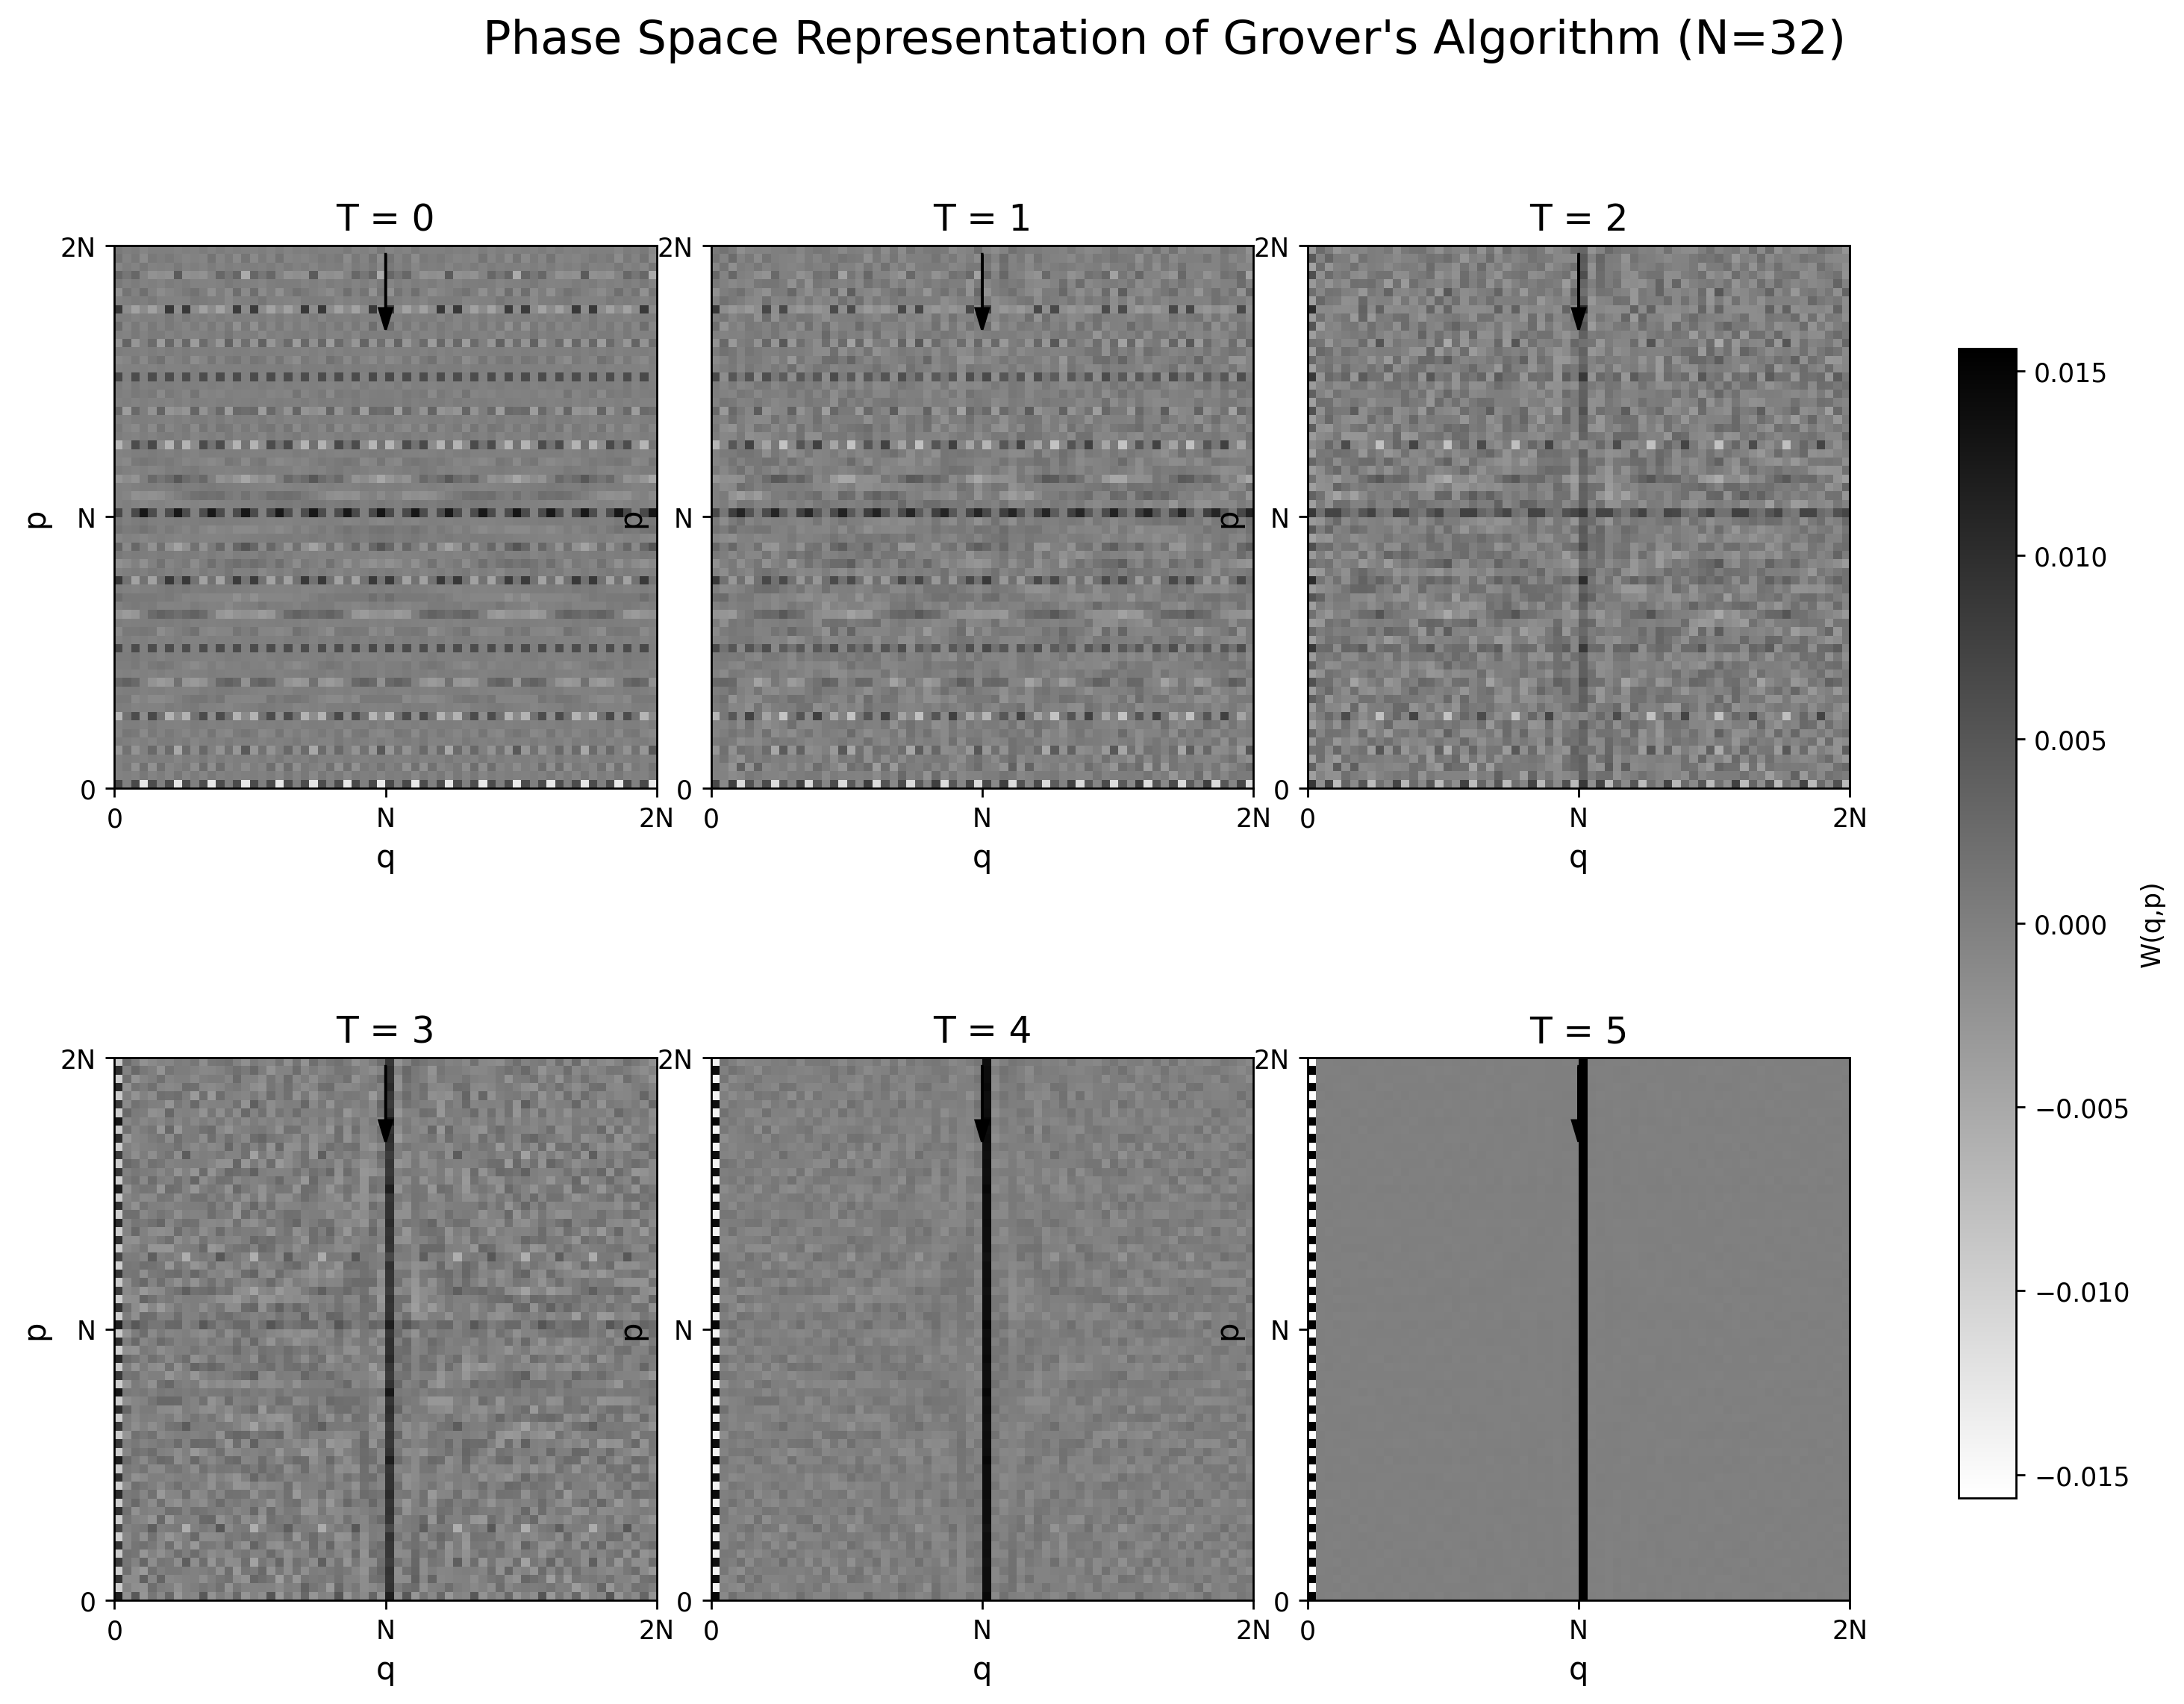

In [11]:
"""
Reproduces Figure 2 from arXiv:quant-ph/0106091v1 using Qiskit.

This script simulates Grover's algorithm for 5 qubits (N=32) and
visualizes the quantum state at each step (T=0 to T=5) using the
discrete Wigner function defined in the paper. This is a GPU-based
simulator of quantum resources (Qiskit-Aer).

This version is compatible with Qiskit 1.x and qiskit-aer 0.14+.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.circuit.library import QFT

plt.rcParams['figure.dpi'] = 250

# --- Constants from the paper ---
N_QUBITS = 5
N_DIM = 2**N_QUBITS  # N = 32
MARKED_ITEM = 16  # Marked item n_0 = 16
INITIAL_K = 1  # Initial momentum state |k=1> (a non-zero momentum state)
N_STEPS = 5  # T=0 to T=5 (total 6 plots)
GRID_SIZE = 2 * N_DIM  # 2N x 2N phase space grid


def get_u_matrix(m: int, n_dim: int) -> np.ndarray:
    """
    Generates the N x N matrix for the cyclic position shift operator U^m.

    U^m |j> = |j+m mod N>

    Args:
        m: The integer power of the shift operator.
        n_dim: The dimension of the Hilbert space (N).

    Returns:
        The (N, N) numpy array representing U^m.
    """
    identity = np.eye(n_dim)
    # np.roll performs a cyclic shift
    return np.roll(identity, m, axis=1)


def get_v_matrix(k: int, n_dim: int) -> np.ndarray:
    """
    Generates the N x N matrix for the momentum shift operator V^k.

    V^k |j> = exp(i * 2 * pi * k * j / N) |j>

    Args:
        k: The integer power of the shift operator.
        n_dim: The dimension of the Hilbert space (N).

    Returns:
        The (N, N) numpy array representing V^k.
    """
    phases = np.exp(1j * 2 * np.pi * k * np.arange(n_dim) / n_dim)
    return np.diag(phases)


def calculate_wigner_function(rho_matrix: np.ndarray, n_dim: int) -> np.ndarray:
    """
    Calculates the discrete Wigner function W(q,p) for a given density matrix.

    Implements W(q,p) = Tr(rho * A(q,p)) using the DFT-based optimization:
    W(q,p) = (1/(2N)^2) * sum_{l, l'} C(l, l') * exp(-i*2*pi*(l'q - lp) / 2N)
    where C(l, l') = Tr(rho * T(l, l'))
    and T(l, l') = U^l * V^l' * exp(i * pi * l * l' / N)

    Args:
        rho_matrix: The (N, N) density matrix of the state.
        n_dim: The dimension of the Hilbert space (N).

    Returns:
        The (2N, 2N) real-valued numpy array for W(q,p).
        The array is indexed as [p, q].
    """
    grid_size = 2 * n_dim
    wigner_grid = np.zeros((grid_size, grid_size), dtype=np.float64)
    coeffs = np.zeros((grid_size, grid_size), dtype=np.complex128)

    # --- Pre-calculate U and V matrices ---
    # We need them for powers up to 2N-1
    u_cache = [get_u_matrix(m, n_dim) for m in range(grid_size)]
    v_cache = [get_v_matrix(k, n_dim) for k in range(grid_size)]

    # --- 1. Calculate the coefficient matrix C(lambda, lambda') ---
    print("  Calculating C(l, l') coefficients...")
    for lam in range(grid_size):
        for lam_p in range(grid_size):
            # T(l, l') = U^l * V^l' * exp(i * pi * l * l' / N)
            phase = np.exp(1j * np.pi * lam * lam_p / n_dim)
            t_mat = (u_cache[lam] @ v_cache[lam_p]) * phase

            # C(l, l') = Tr(rho * T(l, l'))
            coeffs[lam, lam_p] = np.trace(rho_matrix @ t_mat)

    # --- 2. Calculate W(q,p) via 2D DFT-like summation ---
    print("  Calculating W(q, p) from coefficients...")
    p_vals = np.arange(grid_size)
    q_vals = np.arange(grid_size)

    # Create grids for vectorized calculation
    p_grid, q_grid = np.meshgrid(p_vals, q_vals, indexing='ij')

    for lam in range(grid_size):
        for lam_p in range(grid_size):
            # exp(-i*2*pi*(l'q - lp) / 2N)
            exp_phase = np.exp(-1j * 2 * np.pi *
                               (lam_p * q_grid - lam * p_grid) / grid_size)

            wigner_grid += np.real(coeffs[lam, lam_p] * exp_phase)

    # Normalize by (2N)^2 and return
    # We take np.real again to discard tiny imaginary parts from float errors
    return np.real(wigner_grid / (grid_size**2))


def build_grover_circuits(n_qubits: int, marked_item: int,
                          initial_k: int) -> tuple:
    """
    Builds the Qiskit circuits for Grover's algorithm.

    Args:
        n_qubits: The number of qubits (n).
        marked_item: The computational basis state to mark (e.g., 16).
        initial_k: The initial momentum state |k> to use (e.g., 1).

    Returns:
        A tuple containing:
        - qc_init: Circuit to prepare the initial state |s> = QFT|k>
        - qc_grover_step: Circuit for one full Grover iteration G = U_s * U_f
    """
    n = n_qubits
    qr = QuantumRegister(n)

    # --- Initial State |s> = QFT|k> ---
    # Prepare the state |k> in computational basis
    # k=1 is |00001> (Qiskit is little-endian)
    qc_init = QuantumCircuit(qr, name="Init |s>")
    k_str = format(initial_k, f'0{n}b')[::-1]
    for i, bit in enumerate(k_str):
        if bit == '1':
            qc_init.x(i)
    # Apply QFT to get momentum state
    qc_init.append(QFT(n, do_swaps=False), range(n))

    # --- 1. Oracle U_f ---
    # Marks the |marked_item> state.
    # marked_item=16 is |10000> (Qiskit little-endian)
    qc_oracle = QuantumCircuit(qr, name="Oracle U_f")
    marked_str = format(marked_item, f'0{n}b')[::-1]

    # Apply X gates to flip 0-bits
    zero_bits = [i for i, bit in enumerate(marked_str) if bit == '0']
    if zero_bits:
        qc_oracle.x(zero_bits)

    # Apply multi-controlled Z gate (mcp for phase)
    qc_oracle.mcp(np.pi, list(range(n - 1)), n - 1)

    # Apply X gates to flip 0-bits back
    if zero_bits:
        qc_oracle.x(zero_bits)

    # --- 2. Diffuser U_s = 2|s><s| - I ---
    # U_s = QFT * (2|k><k| - I) * QFT_dag
    qc_diffuser = QuantumCircuit(qr, name="Diffuser U_s")

    # Apply QFT_dag
    qc_diffuser.append(QFT(n, do_swaps=False).inverse(), range(n))

    # Apply oracle for |k> state (2|k><k| - I)
    # This is the same logic as the U_f oracle, but for state |k>
    k_str = format(initial_k, f'0{n}b')[::-1]
    zero_bits_k = [i for i, bit in enumerate(k_str) if bit == '0']
    if zero_bits_k:
        qc_diffuser.x(zero_bits_k)
    qc_diffuser.mcp(np.pi, list(range(n - 1)), n - 1)
    if zero_bits_k:
        qc_diffuser.x(zero_bits_k)

    # Apply QFT
    qc_diffuser.append(QFT(n, do_swaps=False), range(n))

    # --- Full Grover Step G = U_s * U_f ---
    # The Grover operator G applies the oracle U_f first, then the diffuser U_s.
    # Qiskit's compose(qc) applies qc *before* the circuit it's called on.
    # So, qc_diffuser.compose(qc_oracle) means: |psi> -> U_f |psi> -> U_s (U_f |psi>)
    qc_grover_step = qc_diffuser.compose(qc_oracle)

    return qc_init, qc_grover_step


def main():
    """
    Main function to run the simulation and generate the plots.
    """
    print("Setting up simulation...")
    print(f"N_QUBITS={N_QUBITS}, N_DIM={N_DIM}, MARKED_ITEM={MARKED_ITEM}")

    # Initialize simulator
    # No method needed; we will get statevector via save_statevector()
    simulator = AerSimulator()

    # Get circuits
    qc_init, qc_grover_step = build_grover_circuits(
        N_QUBITS, MARKED_ITEM, INITIAL_K
    )

    wigner_plots = []
    qc_current = qc_init.copy()

    for t in range(N_STEPS + 1):
        print(f"Calculating state for T = {t}...")

        # 1. Create a copy of the circuit for this specific run.
        qc_to_run = qc_current.copy()
        # 2. Explicitly tell the simulator to save the final statevector.
        qc_to_run.save_statevector()

        # Transpile for simulator
        t_qc = transpile(qc_to_run, simulator)

        # Get statevector from the result
        result = simulator.run(t_qc).result()
        state_vec = result.get_statevector()

        # Get density matrix as numpy array
        rho_t = DensityMatrix(state_vec).data

        print(f"Calculating Wigner function for T = {t}...")
        wigner_t = calculate_wigner_function(rho_t, N_DIM)
        wigner_plots.append(wigner_t)

        # Add next Grover step for next iteration
        if t < N_STEPS:
            qc_current = qc_current.compose(qc_grover_step)

    print("All calculations complete. Generating plots...")

    # --- Plotting ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10),
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.3})
    axes = axes.flatten()

    # Find global min/max for consistent color scaling
    all_wigner_data = np.stack(wigner_plots)
    v_min = all_wigner_data.min()
    v_max = all_wigner_data.max()
    # Use a symmetric range for the divergent colormap
    abs_max = max(abs(v_min), abs(v_max))
    # Avoid zero-range error if all data is 0 (unlikely)
    if abs_max == 0:
        abs_max = 1.0

    # --- FIX: Use Normalize (imported) instead of plt.colors.Normalize ---
    norm = Normalize(vmin=-abs_max, vmax=abs_max)

    # Use 'gray_r' to match paper (black=positive, white=negative)
    cmap = 'gray_r'

    for t in range(N_STEPS + 1):
        ax = axes[t]

        # Plot Wigner function.
        # origin='lower' puts (0,0) at bottom-left.
        # extent sets axes to [q_min, q_max, p_min, p_max]
        im = ax.imshow(
            wigner_plots[t],
            cmap=cmap,
            norm=norm,
            extent=[0, GRID_SIZE, 0, GRID_SIZE],
            origin='lower',
            interpolation='nearest'
        )

        ax.set_title(f"T = {t}", fontsize=14)
        ax.set_xlabel("q", fontsize=12)
        ax.set_ylabel("p", fontsize=12)

        # Add arrow for marked item: q = 16 -> 2*q = 32
        # (x, y, dx, dy)
        ax.arrow(MARKED_ITEM * 2, GRID_SIZE - 1, 0, -GRID_SIZE * 0.1,
                 head_width=1.5, head_length=2.5, fc='black', ec='black')

        # Set axis limits and ticks
        ax.set_xlim(0, GRID_SIZE)
        ax.set_ylim(0, GRID_SIZE)
        ax.set_xticks([0, N_DIM, GRID_SIZE])
        ax.set_yticks([0, N_DIM, GRID_SIZE])
        ax.set_xticklabels(['0', 'N', '2N'])
        ax.set_yticklabels(['0', 'N', '2N'])

    # Hide unused subplot (if any)
    for t in range(N_STEPS + 1, len(axes)):
        axes[t].axis('off')

    # Add a single colorbar
    fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical',
                 shrink=0.8, label='W(q,p)')

    fig.suptitle("Phase Space Representation of Grover's Algorithm (N=32)",
                 fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save and show
    plt.savefig("grover_wigner_plots_qiskit.png")
    print("\nPlot saved as 'grover_wigner_plots_qiskit.png'")
    plt.show()


if __name__ == "__main__":
    main()